# <center> An Introduction to Agent-Based Life Cycle Assessment with Python </center>

This is an introduction to agent-based life cycle assessment (AB-LCA). This notebook will cover the basics of agent-based modeling (ABM) with Mesa, a Python library dedicated to facilitate the building of agent-based models. Then it will present a simple AB-LCA model on plastic recycling that leverages both Mesa and Brightway2, an open source Python framework for LCA.

At the end of this notebook, you will be able to:

* *Understand the Mesa's basic building blocks.*
* *Build a simple ABM.*
* *Link the ABM outputs to an LCA and vice versa.*

This introduction is written in an Jupyter notebook, an online scientific notebook which combines, text, data, images, and programming. It is built upon both Mesa and Brightway2 tutorials.

* [Mesa tutorial](https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html).
* [Brightway2 tutorial](https://github.com/brightway-lca/brightway2/blob/master/notebooks/Getting%20Started%20with%20Brightway2.ipynb).

You should **download this notebook** and follow along!

CONTINUE HERE: ADD A QR CODE + github link

## Getting started

First you need to install the following libraries in your base or a new Python or Conda environment (see [Managing conda environment](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html)):

* CONTINUE HERE: Names of library with version numbers

An easier solution is to install all the libraries at once [using the .yml file](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) in the ACLCA_Workshop_AB-LCA repository CONTINUE HERE: ADD LINK TO THE REPOSITORY.

Then you need to activate the environment (or stay on the base if you added the libraries to your base environment) by clicking Kernel and "change kernel" in the Jupyter notebook menu (you should see the name of the environment as kernel option). If all the libraries are installed, the cell below should run without any issues.

In [1]:
# Libraries used for the ABM.
from mesa import Agent, Model
from mesa.time import RandomActivation, BaseScheduler
from enum import Enum
import math
import networkx as nx
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
import numpy as np
import pandas as pd
import random

# Libraries and magic function used for the LCA and results visualization.
from brightway2 import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Agent-based modeling with Mesa - the Boltzmann wealth model

Mesa fully take advantage of Python object oriented programing capabilities. It defines two main type of objects (Python classes):

* **The model class:** defines the ABM inputs, creates, activates, and removes agents and collect the ABM outputs - only one instance of the model class is created when running the ABM.
* **The agent class:** defines the agents characteristics and their behavior - in Mesa, one agent is one instance of the agent class, thus several instances of the agent class are created when running the ABM. Moreover, several agent classes can be created to represent different agent types.

The agent class inherits the model class, which means any instance of the agent class can access and activate the variables and methods of the model class, respectively. It is very useful to collect outputs and having different agent classes access the same methods (without needing to write them several times).

Besides structuring the ABM through model and agent classes, Mesa has several other classes that makes it easy to build ABMs. For instance:

* **Schedulers:** creates lists of agent class instances - depending on the type of scheduler, agents within the list can be activated in different ways, for instance, in a random or in an orderly fashion. Those classes are part of the Mesa "time" module.
* **Grids:** organize agents spatially, for instance, as a network or within a "checkboard". Those classes are part of the Mesa "space" module.
* **Data collector:** this class from the Mesa "datacollection" module collect outputs when the ABM is running.

The tutorial below is largely taken from the [Mesa tutorial](https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html).

![Mesa architecture [1]](MesaArchitecture.png)

[1] Kazil, J., Masad, D., & Crooks, A. (2020). Utilizing python for agent-based modeling: The mesa framework. Paper presented at the Social, Cultural, and Behavioral Modeling: 13th International Conference, SBP-BRiMS 2020, Washington, DC, USA, October 18–21, 2020, Proceedings 13.

### Introduction: running your first model

#### Let's create an agent type

In [2]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        """Initiate the agent class."""
        # Passes the parameters to the parent class.
        super().__init__(unique_id, model)

        # Creates the agent's variable and set the initial values.
        self.wealth = 1
        
    def step(self):
        """Evolution of agent at each step."""
        # The agent's steps will go here.
        # For demonstration purposes we will print the agent's unique_id.
        print(f"Hi, I am an agent, you can call me {str(self.unique_id)}.")

The *MoneyAgent* class is a subclass of the Mesa agent class. Therefore it inherits the Mesa agent class attributes and methods. 

Here the *MoneyAgent* is very simple, it just has:
* A **unique id** (an integer that is unique for each agent class instance).
* A **model** (both the unique id and model attributes are inherited from the Mesa agent class)
* A variable called "wealth" (an integer). (Note that self denotes that the variable is specific to the instance of the class (so different agents may have different wealths)).
* A method called **step** which is just printing the agent unique id.

#### Now let's build our first agent-based model!

In [3]:
class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N):
        """Initiate the model class."""
        self.num_agents = N
        # Creates scheduler and assign it to the model.
        self.schedule = BaseScheduler(self)

        # Creates agents.
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            # Adds the agent to the scheduler.
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step."""

        # The model's steps will go here for now this will call the step method of each agent and print the agent's unique_id.
        self.schedule.step()

The *MoneyModel* class is a subclass of the Mesa model class. Therefore it inherits the Mesa model class attributes and methods. 

Here the *MoneyModel* is very simple, it just has:
* A number of agent (an integer that represents how many agent will act when the model is running).
* A **scheduler** which determines in which order agents will act.
* A for loop (within the init method of the model) which adds instances of the *MoneyAgent* class in the scheduler (using the "add" method of the BaseScheduler class). Note how the *MoneyAgent* unique_id and model variables are assigned within this loop.
* A method called **step** which is just calling the step method for each agent in the schedule.

Let's run it!

In [4]:
my_first_abm = MoneyModel(10)  # creates a MoneyModel with 10 agents.
my_first_abm.step()  # this line calls the MoneyModel step function, which, in turn, calls the agent own step function.

Hi, I am an agent, you can call me 0.
Hi, I am an agent, you can call me 1.
Hi, I am an agent, you can call me 2.
Hi, I am an agent, you can call me 3.
Hi, I am an agent, you can call me 4.
Hi, I am an agent, you can call me 5.
Hi, I am an agent, you can call me 6.
Hi, I am an agent, you can call me 7.
Hi, I am an agent, you can call me 8.
Hi, I am an agent, you can call me 9.


So as we can see, an ABM is basically a **"for loop"** that loops through all the agents. At each iteration of the loop, the selected agent make some sort of action (it could be optimizing a function, printing a statement (like in this example), choosing an element in a list...). The scheduler determines the order in which the agents act. 

**Quick exercise:** try to change the "BaseScheduler" with the "RandomActivation" and see how the results change when running the ABM.

Now, let's build the *Boltzmann wealth model*...

### Boltzmann wealth model

We just need to modify our agent class so that instead of printing their unique id, agents exchange money with each other.

In [5]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        """Initiate the agent class."""
        # Passes the parameters to the parent class.
        super().__init__(unique_id, model)

        # Creates the agent's variable and set the initial values.
        self.wealth = 1
        
    def give_money(self):
        """Give one unit of money to another agent."""
        # Verifies that the agent has some wealth.
        if self.wealth > 0:
            # Selects another agent.
            other_agent = self.random.choice(self.model.schedule.agents)
            # Gives 1 unit of money to the selected agent.
            if other_agent is not None:
                other_agent.wealth += 1
                self.wealth -= 1
    
    def step(self):
        """Evolution of agent at each step."""
        # The give_money code could be directly written here (rather than in a separate method), however, it is good practice
        # to write the agent's actions in separate methods to make the code clearer.
        self.give_money()

We don't need to re-write the model class at this point. Let's see what is the wealth of our agents before they exchange money with each other.

In [6]:
# We initiate the model with 10 agents.
boltzmann_wealth_abm = MoneyModel(10)

def print_wealth():
    # We access the agents in the scheduler and "ask" them to print their wealth.
    for agent in boltzmann_wealth_abm.schedule.agents:
        print(f"Hi, I am agent {str(agent.unique_id)} and I have {agent.wealth} money.")

# Let's print wealth before any exchange.
print_wealth()

Hi, I am agent 0 and I have 1 money.
Hi, I am agent 1 and I have 1 money.
Hi, I am agent 2 and I have 1 money.
Hi, I am agent 3 and I have 1 money.
Hi, I am agent 4 and I have 1 money.
Hi, I am agent 5 and I have 1 money.
Hi, I am agent 6 and I have 1 money.
Hi, I am agent 7 and I have 1 money.
Hi, I am agent 8 and I have 1 money.
Hi, I am agent 9 and I have 1 money.


Now let's see what is the wealth of our agents after they exchange money with each other

In [7]:
# And now after one exchange.
boltzmann_wealth_abm.step()
print_wealth()

Hi, I am agent 0 and I have 4 money.
Hi, I am agent 1 and I have 0 money.
Hi, I am agent 2 and I have 1 money.
Hi, I am agent 3 and I have 1 money.
Hi, I am agent 4 and I have 1 money.
Hi, I am agent 5 and I have 0 money.
Hi, I am agent 6 and I have 3 money.
Hi, I am agent 7 and I have 0 money.
Hi, I am agent 8 and I have 0 money.
Hi, I am agent 9 and I have 0 money.


There is no reason why agent 0 should always act first and agent 9 should always act last. Moreover, it would be easier if we can collect the wealth of the agents (and maybe compute and collect some other metrics like the gini score) directly. Let's modify the *MoneyModel* to do that.

In [8]:
class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N):
        """Initiate the model class."""
        self.num_agents = N
        self.gini_coef = None
        # Creates scheduler and assign it to the model.
        self.schedule = RandomActivation(self)

        # Creates agents.
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            # Adds the agent to the scheduler.
            self.schedule.add(a)
        
        # Creates a data collector. 
        self.data_collector = DataCollector(model_reporters={"Gini coefficient": "gini_coef"}, 
                                            agent_reporters={"Agent wealth": "wealth"})
            
    def compute_gini(self):
        """Computes the gini score. The gini score is a measure of inequality. A score of 0 indicates perfect equality
        and a score of 1 indicates perfect inequality."""
        agent_wealths = [agent.wealth for agent in self.schedule.agents]
        x = sorted(agent_wealths)
        N = self.num_agents
        B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
        return 1 + (1 / N) - 2 * B

    def step(self):
        """Advance the model by one step."""
        # Computes gini coefficient, collects data and calls the step method of each agent and print the agent's unique_id.
        self.gini_coef = self.compute_gini()
        self.data_collector.collect(self)
        self.schedule.step()

Money exchange often take place several time within a given period and can lead to wealth inequality [2]. Thus, we can run the model several steps and see how the money gets distributed between the agents through time.

[2] Boghosian, B. M. (2019). The inescapable casino. Scientific American(November), 70-77.

In [9]:
boltzmann_wealth_abm = MoneyModel(100)

# Runs the model during 100 steps - note that if a new instance of the model is not initiated at each time steps,
# model and agent variables are not set back to their initial values at each time step, allowing to study how 
# agents and the emergent behavior of the complex system evolve.
for i in range(100):
    boltzmann_wealth_abm.step()

results_model = boltzmann_wealth_abm.data_collector.get_model_vars_dataframe()
results_agents = boltzmann_wealth_abm.data_collector.get_agent_vars_dataframe()

Now we can plot the gini coefficient through time.

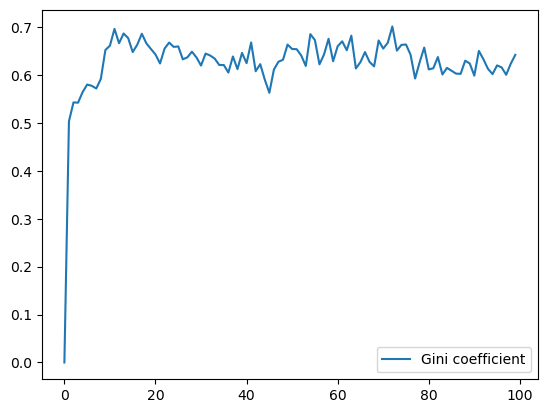

In [10]:
g = sns.lineplot(data=results_model)

We can also plot the wealth distribution among agents.

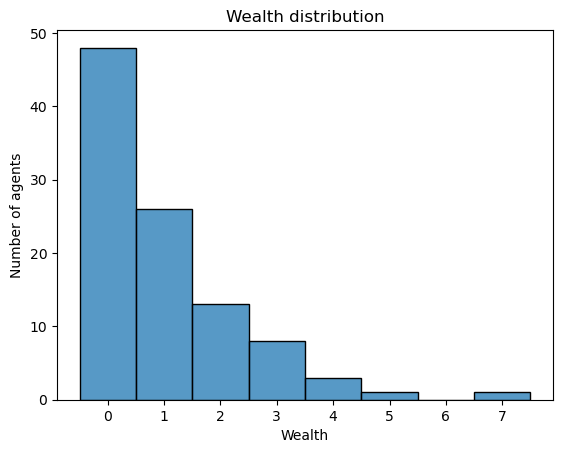

In [11]:
# transform the multi index data frame in a simple data frame so that we can use the Step and AgentID.
results_agents = results_agents.reset_index()
results_agents_final_step = results_agents[results_agents['Step'] == 99]
g = sns.histplot(results_agents_final_step['Agent wealth'].to_list(), discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", 
      ylabel="Number of agents");  # The semicolon is just to avoid printing the object representation.

This very simple model already exibit an interesting behavior typical of complex systems: symmetry breaking. Even if all agents start with equal wealth (1), as soon as we have a variance in wealth (i.e., after the first exchange!), the succeeding transactions will inexorably move wealth from poorer agents to wealthier ones [2]. 

**Quick exercise:** run the model with 2 agents only. How does the gini coefficient evolve? In the MoneyAgent class, replace the following line:

    other_agent = self.random.choice(self.model.schedule.agents)
    
 With the following code:

    other_agent_id = self.unique_id
    while other_agent_id == self.unique_id:
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent_id = other_agent.unique_id
        
Now, re-run the model (don't forget to also re-run the cell containing the MoneyAgent class!). What happens?

## Agent-based life cycle assessment - the case of plastic recycling

In this example we will build a simple agent-based model where agents represent households. At each time step, agents will decide to recycle their plastic waste or not. This decision will be based on the theory of planned behavior (TPB), which assumes that human behaviors are mainly dependent on three factors:

* The **attitude (*A*)** an individual hold towards the behavior (that is, how the behaviour is perceived as favourable or unfavourable).
* The **subjective norm (*SN*)**, which refers to the perceived social pressure to perform or not perform the behavior.
* The **perceived behavioural control (*PBC*)**, which relates to the perceived ease or difficulty of performing the behavior.

In turns, those factors can be dependent on other factors (e.g., the attitude toward the behavior can be influenced by how environmentally friendly the behavior is perceived to be and the perceived behavioural control can be influenced by the financial or cognitive costs of performing the behavior).

We will use **ABM to simulate the adoption of recycling behaviors** within a population and **LCA to compute the environmental impacts** linked to the recycling adoption levels of the agent population under different scenarios.

### Life cycle assessment: building the product system with Brightway2

The [Brightway2 tutorial](https://github.com/brightway-lca/brightway2/blob/master/notebooks/Getting%20Started%20with%20Brightway2.ipynb) is used to build this simple AB-LCA model. The LCA product system is depicted below. It is a simplified version of the system described in Ghosh et al. (2023) [3]. It comprises the production (and use) of virgin plastic, the collection of plastic waste at end of life, and the recycling or landfilling of this waste. Plastic is assumed to be recycled in the same products and credits (avoided virgin plastic production) are therefore given when plastic is recycled. The functional unit is the treatment of plastic at end of life for the population of agent during a given period of time.

<img src="LCA_system.png" alt="drawing" width="400"/>

To model the LCA product system, we first start a new Brightway2 project.

In [12]:
# Starting a new Brightway2 project.
projects.set_current('AB-LCA')
projects.current

'AB-LCA'

The Brightway2 function below import some basic data: a database of elementary flows, some LCIA methods, and some metadata used for importing other databases.

In [13]:
bw2setup()

Biosphere database already present!!! No setup is needed


Now that we have elementary flows and LCIA methods, let's get a LCI database. Similarly to the Brightway2 tutorial, we will use the FORWAST database, as it is both a high quality, comprehensive LCI database, and freely available ([FORWAST](http://forwast.brgm.fr/Overview.asp)).

In [14]:
BW2Package.import_file("forwast.bw2package")

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Title: Writing activities to SQLite3 database:
  Started: 09/18/2023 20:24:20
  Finished: 09/18/2023 20:24:22
  Total time elapsed: 00:00:02
  CPU %: 99.30
  Memory %: 1.09


[Brightway2 SQLiteBackend: forwast]

Let's assign the forwast database to a variable.

In [15]:
db = Database("forwast")

Now we can create the foreground processes of our product system.

In [16]:
def create_foreground_process(process_code, process_name, process_unit):
    # Each code is unique. Once created an error will occur if you try to create the same process again.
    try:
        return db.new_activity(code=process_code, name=process_name, unit=process_unit)
    except:
        print('The process code already exist')

In [17]:
plastic_eol_manag = create_foreground_process('pl_eol_manag', 'Plastic end-of-life management', 'kilogram')
plastic_eol_manag.save()

plastic_rec_land = create_foreground_process('pl_rec_land', 'Plastic recycling / landfilling', 'kilogram')
plastic_rec_land.save()

plastic_waste_collec = create_foreground_process('pl_w_collec', 'Plastic waste collection', 'EUR2003')
plastic_waste_collec.save()

Let's find processes for virgin plastic production, plastic recycling, and plastic landfilling in forwast.

In [18]:
list_process = db.search("plastic*")
print(list_process)

['_42 Recycling of plastics basic, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']), '_40 Recycling of plastics basic, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']), '_41 Plastics basic, virgin, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']), '_44 Rubber and plastic products, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']), '_42 Rubber and plastic products, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']), '103 Waste treatment, Incineration of waste, Plastic, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']), '118 Waste treatment, Landfill of waste, Plastic, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']), '_94 Waste treatment, Incineration of waste, Plastic, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']), '109 Waste treatment, Landfill of waste, Plastic, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']), 'Plastic recycling / landfilling' (kilogram, GLO, None), 'Plastic waste collection' (EUR2003, GLO, None), 'Plastic end-of-life managemen

In [19]:
virgin_plastic = [p for p in list_process if 'Plastics basic, virgin' in str(p) and 'EU27' in str(p)][0]
print(virgin_plastic)

'_41 Plastics basic, virgin, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])


In [20]:
plastic_recycling = [p for p in list_process if 'Recycling of plastics' in str(p) and 'EU27' in str(p)][0]
print(plastic_recycling)

'_42 Recycling of plastics basic, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])


In [21]:
plastic_landfilling = [p for p in list_process if 'Landfill of waste, Plastic' in str(p) and 'EU27' in str(p)][0]
print(plastic_landfilling)

'118 Waste treatment, Landfill of waste, Plastic, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])


Now we can add the background processes to the plastic recycling / landfilling foreground process.

In [22]:
# Careful! Each time .new_exchange.save() is used it adds a new exchange to the process! 
# Thus, let's build a function that replaces exchanges rather than adding them:

def adding_and_replacing_exchange(process, exchange, exc_amount, exc_unit, replacing):
    if not replacing:
        exc_exist = False
        for exc in process.exchanges():
            if exc['input'] == exchange.key:
                exc_exist = True
        if not exc_exist:
            process.new_exchange(input=exchange, amount=exc_amount, unit=exc_unit, type='technosphere').save()
            process.save()
        else:
            print('Exchange already exist')
    else:
        for exc in process.exchanges():
            if exc['input'] == exchange.key:
                exc.delete()
                process.new_exchange(input=exchange, amount=exc_amount, unit=exc_unit, type='technosphere').save()
                process.save()

In [23]:
adding_and_replacing_exchange(plastic_rec_land, virgin_plastic, 0, "kilogram", False)
adding_and_replacing_exchange(plastic_rec_land, plastic_recycling, 0, "kilogram", False)
adding_and_replacing_exchange(plastic_rec_land, plastic_landfilling, 0, "kilogram", False)

We can also use the "adding_and_replacing_exchange" function to build the plastic waste collection foreground process. Let's first find a process for transportation in forwast.

In [24]:
list_process = db.search("transport*")
print(list_process)

['_76 Land transport and transport via pipelines, DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003']), '_85 Land transport and transport via pipelines, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003']), '_87 Air transport, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003']), '_77 Transport by ship, DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003']), '_86 Transport by ship, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003']), '_78 Air transport, DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003']), '_72 Transport equipment n.e.c., EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003']), '_63 Transport equipment n.e.c., DK' (EUR2003, GLO, ['Input Output', 'Denmark 2003'])]


In [25]:
transport_plastic_waste = [p for p in list_process if 'Land transport' in str(p) and 'EU27' in str(p)][0]
print(transport_plastic_waste)

'_85 Land transport and transport via pipelines, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003'])


In [26]:
adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, 0, "kilogram", False)

Now we can add the plastic recycling / landfilling and plastic waste collection processes to the plastic end-of-life management foreground process.

In [27]:
adding_and_replacing_exchange(plastic_eol_manag, plastic_rec_land, 1, "kilogram", False)
adding_and_replacing_exchange(plastic_eol_manag, plastic_waste_collec, 1, "kilogram", False)

Our product system is now built! Let's look at it...

In [28]:
# We can print the exchanges in our three foreground processes.

foreground_processes = [plastic_eol_manag, plastic_waste_collec, plastic_rec_land]

print('Those are the exchanges in our foreground processes:')
for process in foreground_processes:
    print(' ')
    print(process.as_dict()['name'])
    for exc in process.exchanges():
        print(exc)

Those are the exchanges in our foreground processes:
 
Plastic end-of-life management
Exchange: 1 kilogram 'Plastic recycling / landfilling' (kilogram, GLO, None) to 'Plastic end-of-life management' (kilogram, GLO, None)>
Exchange: 1 EUR2003 'Plastic waste collection' (EUR2003, GLO, None) to 'Plastic end-of-life management' (kilogram, GLO, None)>
 
Plastic waste collection
Exchange: 0 EUR2003 '_85 Land transport and transport via pipelines, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003']) to 'Plastic waste collection' (EUR2003, GLO, None)>
 
Plastic recycling / landfilling
Exchange: 0 kilogram '_41 Plastics basic, virgin, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']) to 'Plastic recycling / landfilling' (kilogram, GLO, None)>
Exchange: 0 kilogram '_42 Recycling of plastics basic, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']) to 'Plastic recycling / landfilling' (kilogram, GLO, None)>
Exchange: 0 kilogram '118 Waste treatment, Landfill of waste, Plastic, EU27' (kilogram

Note that for now we haven't assigned any amount of transport, virgin plastic production, plastic recycling, and plastic landfilling. **Those amounts will be determined by the ABM.** However, we can already choose an impact methodology and verify that our system does not cause any impacts (since the foreground processes requires 0 amount of background processes and do not have in situ emissions or resource use).

In [29]:
# We can see all LCIA methods that are included in brightway: 
print(list(methods))

[('CML v4.8 2016 no LT', 'acidification no LT', 'acidification (incl. fate, average Europe total, A&B) no LT'), ('CML v4.8 2016 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('CML v4.8 2016 no LT', 'ecotoxicity: freshwater no LT', 'freshwater aquatic ecotoxicity (FAETP inf) no LT'), ('CML v4.8 2016 no LT', 'ecotoxicity: marine no LT', 'marine aquatic ecotoxicity (MAETP inf) no LT'), ('CML v4.8 2016 no LT', 'ecotoxicity: terrestrial no LT', 'terrestrial ecotoxicity (TETP inf) no LT'), ('CML v4.8 2016 no LT', 'energy resources: non-renewable no LT', 'abiotic depletion potential (ADP): fossil fuels no LT'), ('CML v4.8 2016 no LT', 'eutrophication no LT', 'eutrophication (fate not incl.) no LT'), ('CML v4.8 2016 no LT', 'human toxicity no LT', 'human toxicity (HTP inf) no LT'), ('CML v4.8 2016 no LT', 'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT'), ('CML v4.8 2016 no LT', 'ozone depletion n

In [30]:
# Let's only select the 2021 IPCC method for the climate change category calculated at a 100 year horizon.
method_name = [m for m in methods if 'IPCC 2021' in str(m) and 'climate change' in str(m) and 
               'global warming potential (GWP100)' in str(m)]
print(method_name)

[('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021 no LT', 'climate change: biogenic no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021 no LT', 'climate change: biogenic, including SLCFs no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021 no LT', 'climate change: fossil no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021 no LT', 'climate change: fossil, including SLCFs no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021 no LT', 'climate change: including SLCFs no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021 no LT', 'climate change: land use no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021 no LT', 'climate change: land use, including SLCFs no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021', 'climate change', 'global warming potential (GWP100)'), ('IPCC 2021', 'climate change: biogenic', 'global warming potential (GWP100)'), ('IPCC 2021', 'climat

In [31]:
# We need further refining.
method_name = [m for m in methods if 'IPCC 2021' == m[0] and 'climate change' == m[1] and 
               'global warming potential (GWP100)' == m[2]]
print(method_name)

[('IPCC 2021', 'climate change', 'global warming potential (GWP100)')]


In [32]:
# Let's calculate the climate change impact.

def compute_lca_score(product_system, impact_method):
    lca = LCA({product_system: 1}, impact_method)
    lca.lci()
    lca.lcia()
    print(f"The climate change impact is {lca.score} kg CO₂ eq.")
    
compute_lca_score(plastic_eol_manag, method_name[0])

The climate change impact is 0.0 kg CO2 eq.


Note that in Forwast, recycling processes outputs are negative (since their outputs replaces inputs in other economic sectors). Thus, we already give ourselves credits when using the plastic recycling process. Let's look at all our background processes...

In [33]:
# We can print the climate change impacts of our four background processes.

background_processes = [virgin_plastic, plastic_recycling, plastic_landfilling, transport_plastic_waste]

for process in background_processes:
    print(f"For {process.as_dict()['name']}:")
    compute_lca_score(process, method_name[0])
    print(' ')

For _41 Plastics basic, virgin, EU27:
The climate change impact is 2.796754962362626 kg CO2 eq.
 
For _42 Recycling of plastics basic, EU27:
The climate change impact is -1.9384368411331208 kg CO2 eq.
 
For 118 Waste treatment, Landfill of waste, Plastic, EU27:
The climate change impact is 0.18673082232495108 kg CO2 eq.
 
For _85 Land transport and transport via pipelines, EU27:
The climate change impact is 2.985948186815122 kg CO2 eq.
 


### Agent-based life cycle assessment model

Now that we know how to build our product system and compute impact scores, we can build the ABM and **link its outputs** to the LCA model.

#### Let's create a household agent class

The agent will make a simple decision, based on the TPB: recycling or landfilling plastic waste.

In [131]:
class HouseholdAgent(Agent):
    """Household agent that recycle or landfill plastic waste."""
    # The agent could be initialized with more arguments. However, it is often easier to keep all inputs as model arguments
    # since agents can always access all variables and methods of the model.
    def __init__(self, unique_id, model):
        """Initiates agent.
        
        Args:
            unique_id (int): agent #, also relate to the node # in the network.
            model (class instance): the agent class inherit the model class.
        """
        super().__init__(unique_id, model)
        self.plastic_waste = self.model.plastic_waste
        self.recycling_cost = random.choice(self.model.behavior_costs['recycling'])
        self.landfilling_cost = self.model.behavior_costs['landfilling']
        self.recycling_attitude = random.choice(self.model.behavior_attitudes['recycling'])
        self.landfilling_attitude = self.model.behavior_costs['landfilling']
        dice = random.random()
        if dice < self.model.initial_recycling_rate:
            self.recycling = True
        else:
            self.recycling = False

    def normalize_scores(self, *args):
        """Normalizes scores to the option with the highest score.
        
        Args:
            *args (floats): scores that need to be normalized.
        
        Returns:
            list: the list of normalized scores.
        """
        list_scores = []
        for arg in args:
            list_scores.append(arg)
        max_score = max(list_scores)
        normalized_scores = []
        for score in list_scores:
            if max_score != 0:
                score = score / max_score
            else:
                score = 0
            normalized_scores.append(score)
        return normalized_scores
            
    def eol_pathway_decision(self, recycling_cost, landfilling_cost, recycling_attitude, landfilling_attitude, grid):
        """Agent decision-making function.
        
        Args:
            recycling_cost (float): recycling cost.
            landfill_cost (float): landfill cost.
            recycling_attitude (float): recycling attitude.
            landfill_attitude (float): landfill attitude.
            grid (Mesa grid object building on a Networkx graph): social network relating asset owner agents. 
        """
        # Collates recycling and landfill costs and attitudes and normalize values as to not skew decision (subjective norms,
        # attitude, and perceived behavioral scores should be between 0 and 1, the weights then define which factor has 
        # more influence than others).
        perceived_behavioral_control_scores = self.normalize_scores(self.recycling_cost, self.landfilling_cost)
        attitude_scores = self.normalize_scores(self.recycling_attitude, self.landfilling_attitude)
        # Get all the agent neighbors (in the social network) in a list.
        neighbors_nodes = grid.get_neighbors(self.unique_id, include_center=False)
        # Assign a score to the recycling and landfill behavior depending on the number of neighbors that have adopted that 
        # behavior (e.g., if all neighbors recycle: subjective_norms_scores = [1, 0] if they all landfill: 
        # subjective_norms_scores = [0, 1]). Note that for each of the TPB factors, the recycling score is the first element
        # of the list and the landfilling score is the second element of the list.
        subjective_norms_scores = []
        for recycling in [True, False]:
            list_agent_behavior = [
                agent for agent in grid.get_cell_list_contents(neighbors_nodes) if
                getattr(agent, 'recycling') == recycling]
            if len(neighbors_nodes) != 0:
                subjective_norms_score = len(list_agent_behavior) / len(neighbors_nodes)
            else:
                subjective_norms_score = 0
            subjective_norms_scores.append(subjective_norms_score)
        # Compute total scores accounting for the weight of each factor.
        total_scores = [self.model.decision_weights['perceived behavioural control'] * x + 
                        self.model.decision_weights['subjective norms'] * y +
                        self.model.decision_weights['attitude'] * z
                        for x, y, z in zip(perceived_behavioral_control_scores, subjective_norms_scores, attitude_scores)]
        # Agent chooses the decision with the highest total score (total_scores[0] and total_scores[1] correspond to the 
        # score attributed to the recycling and landfill behaviors respectively).
        decision = total_scores.index(max(total_scores))
        if decision == 0:
            self.recycling = True
        else:
            self.recycling = False
    
    def update_collector(self):
        """Updates simulation outputs collector."""
        if self.recycling:
            self.model.recycled_plastic += self.plastic_waste
            self.model.recycling_costs += self.recycling_cost
        else:
            self.model.landfilled_plastic += self.plastic_waste
            self.model.landfilling_costs += self.landfilling_cost
        
    def step(self):
        """Evolution of agent at each step."""
        self.eol_pathway_decision(self.recycling_cost, self.landfilling_cost, self.recycling_attitude, 
                                  self.landfilling_attitude, self.model.grid)
        self.update_collector()

#### Let's create the model

In [132]:
class PlasticRecyclingModel(Model):
    """A model with some number of agents. Creates and activates agents. Also defines inputs (default values can be 
    changed by user) and collect outputs."""
    def __init__(self, 
                 seed=None, 
                 num_households=100, 
                 plastic_waste=1, 
                 behavior_costs={'recycling': [0.6, 1], 'landfilling': 0.5},
                 behavior_attitudes={'recycling': [0.4, 1], 'landfilling': 0.5},
                 initial_recycling_rate=0.1, 
                 social_network={'node_degree': 7, 'rewiring_prob': 0.1}, 
                 decision_weights={'attitude': 0.3, 'subjective norms': 0.3, 'perceived behavioural control': -0.3}):
        """Initiates model.
        
        Args:
            seed (int, optional): number used to initialize the random generator. Defaults to None.
            num_asset_owners (int): number of household agents. Default to 100.
            plastic_waste (float): amount of monthly plastic waste per household. Default to 1.
            behavior_costs (dict): possible financial and cognitive costs for the recycling and landfilling behaviors. 
                Default to {'recycling': [0.5, 1], 'landfilling': 0.5}.
            behavior_attitudes (dict): possible attitudes for the recycling and landfilling behaviors. Default to 
                {'recycling': [0.5, 1], 'landfilling': 0.5}.
            initial_recycling_rate (float): intial proportion of asset owners that recycled their PV waste. Default to 0.1.
            social_network (dict): parameters to draw a small-world network. Default to {'node_degree': 7, 
                'rewiring_prob': 0.1}.
            decision_weights (dict): weights of the different factors influencing asset owners to recycle PV. Default to 
                {'attitude': -0.3, 'subjective norms': 0.3, 'perceived behavioural control': 0.3}
        """
        
        # Fixes random generator.
        self.seed = seed
        random.seed(self.seed)
        
        # Variables from inputs (value defined externally).
        self.num_households = num_households
        self.plastic_waste = plastic_waste
        self.behavior_costs = behavior_costs
        self.behavior_attitudes = behavior_attitudes
        self.initial_recycling_rate = initial_recycling_rate
        self.social_network = social_network
        self.decision_weights = decision_weights
        
        # Internal variables.
        self.schedule = RandomActivation(self)
        self.recycled_plastic = 0
        self.landfilled_plastic = 0
        self.recycling_costs = 0
        self.landfilling_costs = 0
        self.climate_change_impact = 0
        
        # Creates social network and Mesa grid.
        self.network = nx.watts_strogatz_graph(self.num_households, self.social_network['node_degree'],
                                          self.social_network['rewiring_prob'], seed=random.seed(self.seed))
        self.grid = NetworkGrid(self.network)
        
        # Creates a data collector.
        self.data_collector = DataCollector(model_reporters={"Recycled plastic (kg)": "recycled_plastic",
                                                            "Landfilled plastic (kg)": "landfilled_plastic",
                                                            "Climate change impact (kg CO₂ eq)": "climate_change_impact"})
        
        def create_agents(schedule, num_agents):
            for i in range(num_agents):
                a = HouseholdAgent(i, self)
                schedule.add(a)
                self.grid.place_agent(a, i)
        
        # Creates agents.
        create_agents(self.schedule, self.num_households)
    
    @staticmethod
    def life_cycle_assessment(recycled_plastic, landfilled_plastic, recycling_costs, landfilling_costs):
        """
        Updates the product system with new values and calculates the climate change impact.
        
        Args:
            recycled_plastic (float): total amount of recycled plastic.
            landfilled_plastic (float): total amount of landfilled plastic.
            recycling_costs (float): total cost of recycling, used to calculate the waste collection cost.
            landfilling_costs (float): total cost of landfilling, used to calculate the waste collection cost.
        """
        # Re-initializes the product system.
        adding_and_replacing_exchange(plastic_rec_land, virgin_plastic, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, plastic_recycling, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, plastic_landfilling, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, 0, "kilogram", True)
        
        # Replaces values in the product system.
        adding_and_replacing_exchange(plastic_rec_land, plastic_recycling, recycled_plastic, "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, plastic_landfilling, landfilled_plastic, "kilogram", True)
        # Let's assume half of the recycling and landfilling costs are due to waste collection.
        waste_collection_recycling_costs = recycling_costs / 2
        waste_collection_landfill_costs = landfilling_costs / 2
        adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, waste_collection_recycling_costs,
                                      "kilogram", True)
        adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, waste_collection_landfill_costs,
                                      "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, virgin_plastic, recycled_plastic + landfilled_plastic,
                                      "kilogram", True)
        
        # Computes the lca score.
        lca = LCA({plastic_eol_manag: 1}, method_name[0])
        lca.lci()
        lca.lcia()
        
        return lca.score
        
    def step(self):
        """Advances the model by one step."""
        self.schedule.step()
        self.climate_change_impact = self.life_cycle_assessment(self.recycled_plastic, self.landfilled_plastic,
                                                                self.recycling_costs, self.landfilling_costs)
        self.data_collector.collect(self)

### Running the model and visualizing results

In [133]:
seed = 0
model = PlasticRecyclingModel(seed=seed)

# Run the model for 12 steps (one year).
for i in range(12):
    print('Step', i)
    model.step()

results_model = model.data_collector.get_model_vars_dataframe()

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11


In [134]:
results_model.head(12)

Recycled plastic (kg)  Landfilled plastic (kg)  \
0                       0                      100   
1                       0                      200   
2                       0                      300   
3                       0                      400   
4                       0                      500   
5                       0                      600   
6                       0                      700   
7                       0                      800   
8                       0                      900   
9                       0                     1000   
10                      0                     1100   
11                      0                     1200   

    Climate change impact (kg CO₂ eq)  
0                          372.997283  
1                          745.994566  
2                         1118.991849  
3                         1491.989133  
4                         1864.986416  
5                         2237.983699  
6                         2610.980982  
7                         2983.978265  
8                         3356.975548  
9                         3729.972831  
10                        4102.970115  
11                        4475.967398

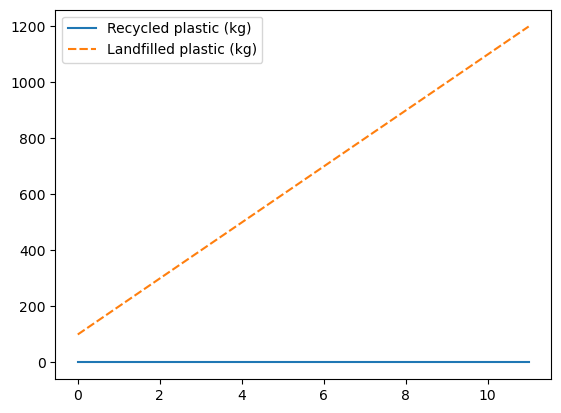

In [135]:
# Plot results.
waste_fate = results_model.drop('Climate change impact (kg CO₂ eq)', axis=1)
sns.lineplot(data=waste_fate);

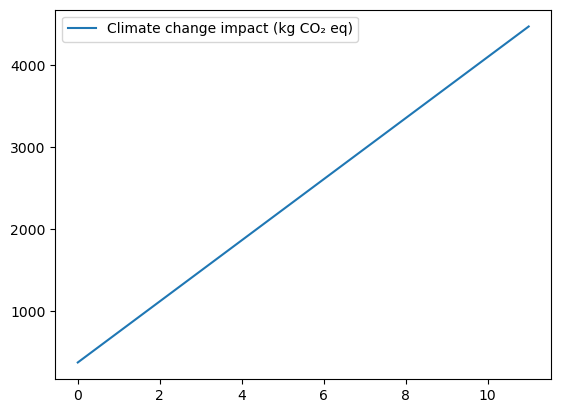

In [136]:
# Plot results.
cc_impact = results_model.drop(['Recycled plastic (kg)', 'Landfilled plastic (kg)'], axis=1)
sns.lineplot(data=cc_impact);

Computing the LCA at each time step is costly. Let's just compute it at the end. Like this the model will run faster and we can experiment with the ABM.

In [137]:
class PlasticRecyclingModel(Model):
    """A model with some number of agents. Creates and activates agents. Also defines inputs (default values can be 
    changed by user) and collect outputs."""
    def __init__(self, 
                 seed=None, 
                 num_households=100, 
                 plastic_waste=1, 
                 behavior_costs={'recycling': [0.6, 1], 'landfilling': 0.5},
                 behavior_attitudes={'recycling': [0.4, 1], 'landfilling': 0.5},
                 initial_recycling_rate=0.1, 
                 social_network={'node_degree': 7, 'rewiring_prob': 0.1}, 
                 decision_weights={'attitude': 0.3, 'subjective norms': 0.3, 'perceived behavioural control': -0.3}):
        """Initiates model.
        
        Args:
            seed (int, optional): number used to initialize the random generator. Defaults to None.
            num_asset_owners (int): number of household agents. Default to 100.
            plastic_waste (float): amount of monthly plastic waste per household. Default to 1.
            behavior_costs (dict): possible financial and cognitive costs for the recycling and landfilling behaviors. 
                Default to {'recycling': [0.5, 1], 'landfilling': 0.5}.
            behavior_attitudes (dict): possible attitudes for the recycling and landfilling behaviors. Default to 
                {'recycling': [0.5, 1], 'landfilling': 0.5}.
            initial_recycling_rate (float): intial proportion of asset owners that recycled their PV waste. Default to 0.1.
            social_network (dict): parameters to draw a small-world network. Default to {'node_degree': 7, 
                'rewiring_prob': 0.1}.
            decision_weights (dict): weights of the different factors influencing asset owners to recycle PV. Default to 
                {'attitude': 0.3, 'subjective norms': 0.3, 'perceived behavioural control': -0.3}
        """
        
        # Fixes random generator.
        self.seed = seed
        random.seed(self.seed)
        
        # Variables from inputs (value defined externally).
        self.num_households = num_households
        self.plastic_waste = plastic_waste
        self.behavior_costs = behavior_costs
        self.behavior_attitudes = behavior_attitudes
        self.initial_recycling_rate = initial_recycling_rate
        self.social_network = social_network
        self.decision_weights = decision_weights
        
        # Internal variables.
        self.schedule = RandomActivation(self)
        self.recycled_plastic = 0
        self.landfilled_plastic = 0
        self.recycling_costs = 0
        self.landfilling_costs = 0
        self.climate_change_impact = 0
        
        # Creates social network and Mesa grid.
        self.network = nx.watts_strogatz_graph(self.num_households, self.social_network['node_degree'],
                                          self.social_network['rewiring_prob'], seed=random.seed(self.seed))
        self.grid = NetworkGrid(self.network)
        
        # Creates a data collector.
        self.data_collector = DataCollector(model_reporters={"Recycled plastic (kg)": "recycled_plastic",
                                                            "Landfilled plastic (kg)": "landfilled_plastic",
                                                            "Climate change impact (kg CO₂ eq)": "climate_change_impact"})
        
        def create_agents(schedule, num_agents):
            for i in range(num_agents):
                a = HouseholdAgent(i, self)
                schedule.add(a)
                self.grid.place_agent(a, i)
        
        # Creates agents.
        create_agents(self.schedule, self.num_households)
    
    @staticmethod
    def life_cycle_assessment(recycled_plastic, landfilled_plastic, recycling_costs, landfilling_costs):
        """
        Updates the product system with new values and calculates the climate change impact.
        
        Args:
            recycled_plastic (float): total amount of recycled plastic.
            landfilled_plastic (float): total amount of landfilled plastic.
            recycling_costs (float): total cost of recycling, used to calculate the waste collection cost.
            landfilling_costs (float): total cost of landfilling, used to calculate the waste collection cost.
        """
        # Re-initializes the product system.
        adding_and_replacing_exchange(plastic_rec_land, virgin_plastic, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, plastic_recycling, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, plastic_landfilling, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, 0, "kilogram", True)
        
        # Replaces values in the product system.
        adding_and_replacing_exchange(plastic_rec_land, plastic_recycling, recycled_plastic, "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, plastic_landfilling, landfilled_plastic, "kilogram", True)
        # Let's assume half of the recycling and landfilling costs are due to waste collection.
        waste_collection_recycling_costs = recycling_costs / 2
        waste_collection_landfill_costs = landfilling_costs / 2
        adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, waste_collection_recycling_costs,
                                      "kilogram", True)
        adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, waste_collection_landfill_costs,
                                      "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, virgin_plastic, recycled_plastic + landfilled_plastic,
                                      "kilogram", True)
        
        # Computes the lca score.
        lca = LCA({plastic_eol_manag: 1}, method_name[0])
        lca.lci()
        lca.lcia()
        
        return lca.score
        
    def step(self):
        """Advances the model by one step."""
        self.schedule.step()
        # self.climate_change_impact = self.life_cycle_assessment(self.recycled_plastic, self.landfilled_plastic,
        #                                                        self.recycling_costs, self.landfilling_costs)
        self.data_collector.collect(self)

In [138]:
seed = 0
model = PlasticRecyclingModel(seed=seed)

# Run the model for 12 steps (one year).
for i in range(12):
    print('Step', i)
    model.step()

results_model = model.data_collector.get_model_vars_dataframe()

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11


Much faster... Now, what if attitude was the only factor affecting households' decisions?

In [139]:
seed = 0
model = PlasticRecyclingModel(seed=seed, 
                              decision_weights={'attitude': 0.3, 'subjective norms': 0, 
                                                'perceived behavioural control': -0})

# Run the model for 12 steps (one year).
for i in range(12):
    model.step()

results_model = model.data_collector.get_model_vars_dataframe()

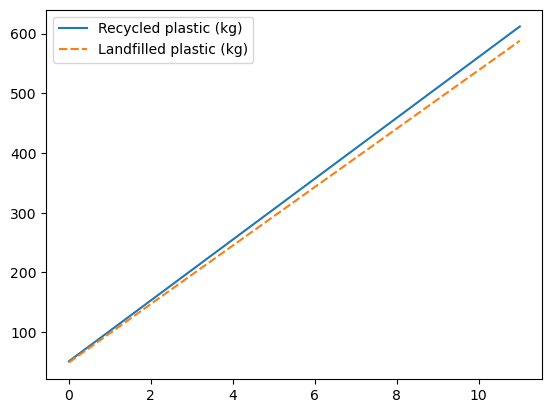

In [140]:
# Plot results.
waste_fate = results_model.drop('Climate change impact (kg CO₂ eq)', axis=1)
sns.lineplot(data=waste_fate);

Because there is a 50/50 chance that an agent has a great attitude towards recycling (i.e., viewed as a prefered choice over landfilling), we have about half the waste that ends up landfilled. Let's do the LCA.

In [141]:
lca_score = model.life_cycle_assessment(model.recycled_plastic, model.landfilled_plastic, 
                                        model.recycling_costs, model.landfilling_costs)

print(f"The climate change impact is {lca_score} kg CO₂ eq.")

The climate change impact is 2718.514715050573 kg CO₂ eq.


Because we have more households that recycled when only attitude is factored in, the climate change impact is lower.

**Quick exercise:** try to change the initial recycling rate to values above 0.3 and have subjective norms be the only factor affecting households' decisions.

We can also plot the final amount of recycled plastic as a function of the initial recycling rate.

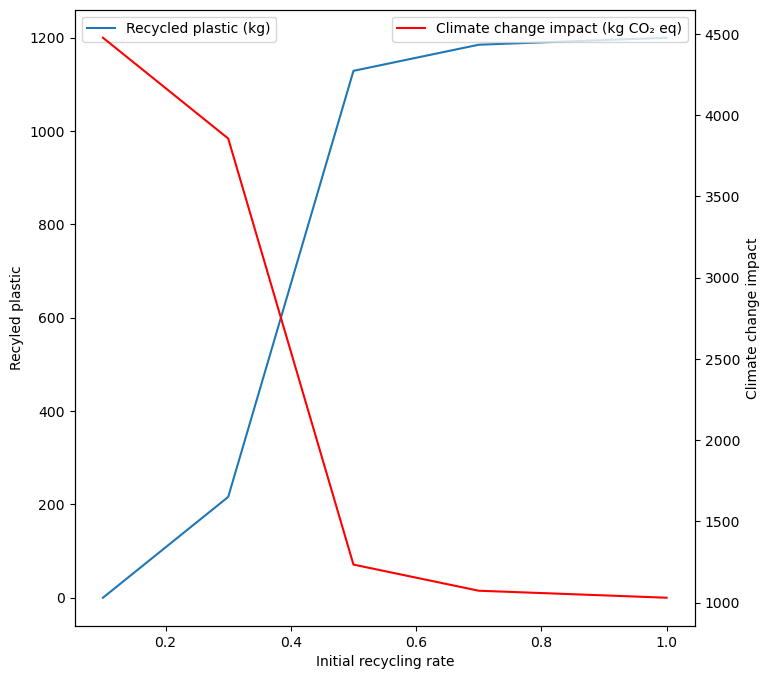

In [142]:
seed = 0
initial_recycling_rates = [0.1, 0.3, 0.5, 0.7, 1]
final_recycling_rates = []
lca_scores = []

# Run the model for ten steps for different initial recycling rates.
for initial_recycling_rate in initial_recycling_rates:
    model = PlasticRecyclingModel(seed=seed, initial_recycling_rate=initial_recycling_rate, 
                                  decision_weights={'attitude': 0, 'subjective norms': 0.3, 
                                                'perceived behavioural control': -0})
    for i in range(12):
        model.step()
    final_recycling_rates.append(model.recycled_plastic)
    lca_score = model.life_cycle_assessment(model.recycled_plastic, model.landfilled_plastic, 
                                        model.recycling_costs, model.landfilling_costs)
    lca_scores.append(lca_score)

# Plot results.
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax1.plot(initial_recycling_rates, final_recycling_rates, label='Recycled plastic (kg)')
ax1.legend(loc=0)
ax1.set_xlabel('Initial recycling rate')
ax1.set_ylabel('Recyled plastic')
ax2.plot(initial_recycling_rates, lca_scores, label='Climate change impact (kg CO₂ eq)', color='red')
ax2.set_ylabel('Climate change impact')
plt.legend();

Let's find a situation where recycling behaviors are adopted over time (to do that, we can decrease the recycling cost which could correspond to a situation where recycling is made easier, e.g., by developing curbside recycling programs). How does it look like in terms of the agents?

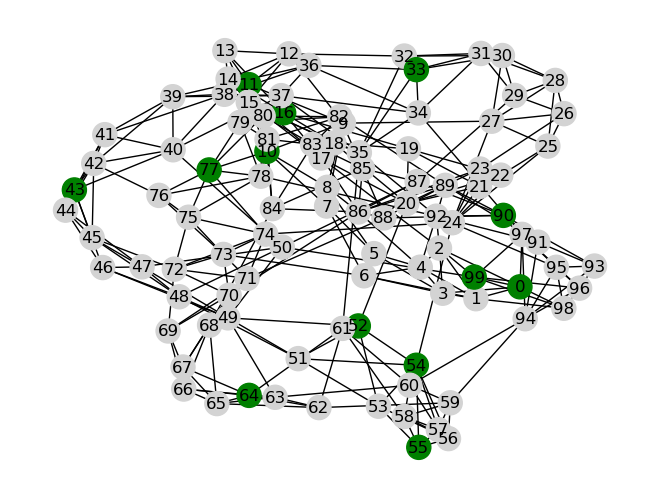

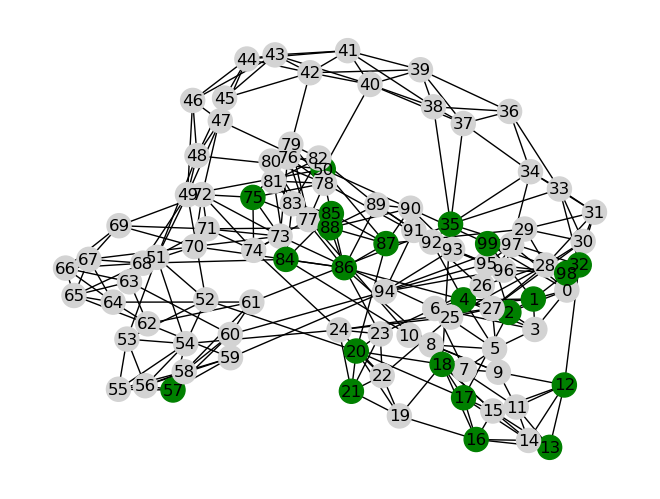

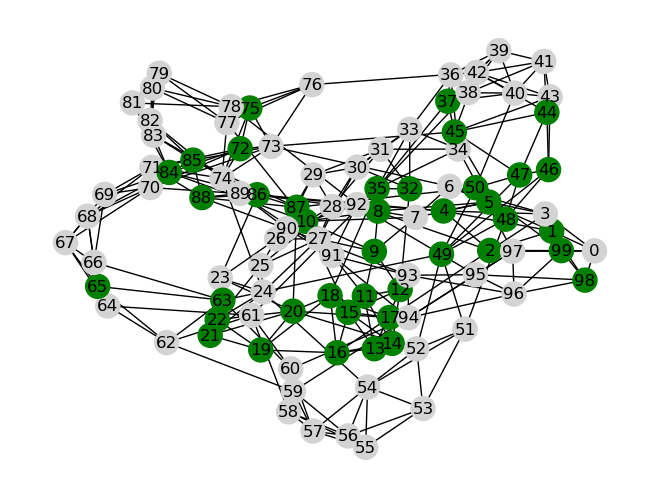

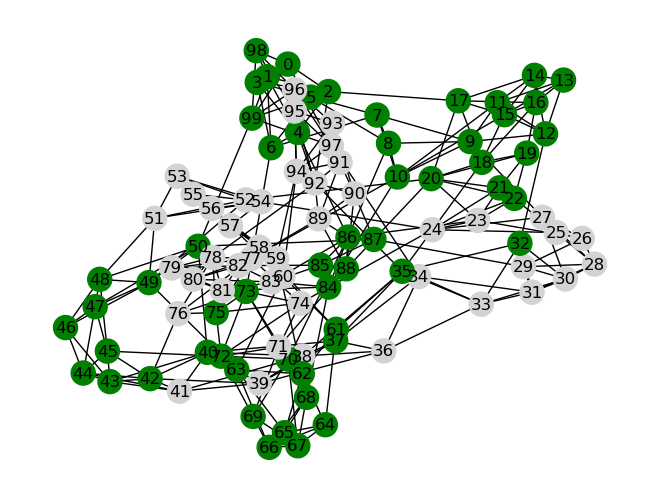

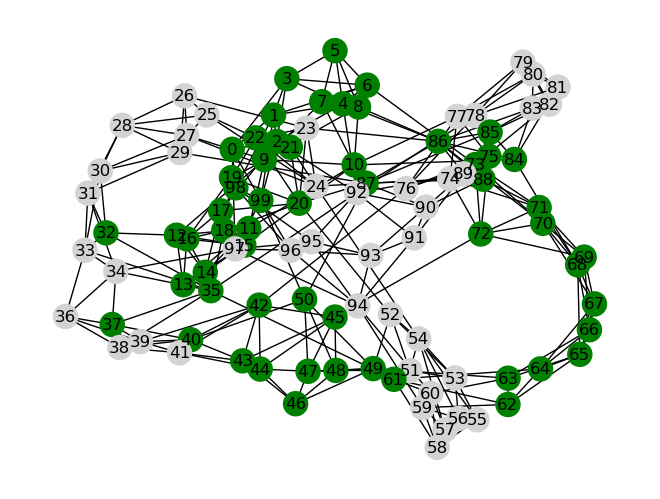

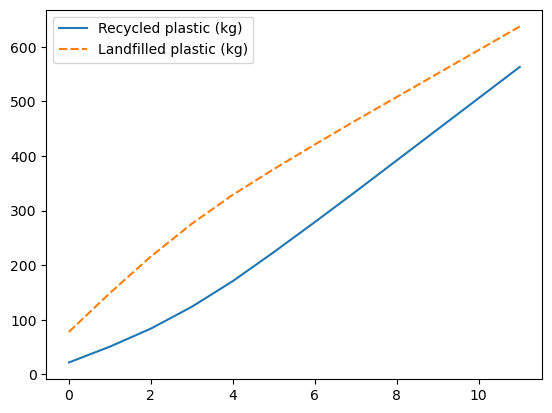

In [143]:
seed = 0
model = PlasticRecyclingModel(seed=seed, initial_recycling_rate=0.1, 
                              behavior_costs={'recycling': [0.3, 0.7], 'landfilling': 0.5},
                              decision_weights={'attitude': 0.3, 'subjective norms': 0.3,
                                                'perceived behavioural control': -0.3})

# Run the model for 12 steps (one year) and color agents according to their behavior.    
for i in range(12):
    if i == 0 or i == 1 or i == 4 or i == 8 or i == 11:
        cmap = []
        for a in model.schedule.agents:
            if a.recycling:
                cmap.append('green')
            else:
                cmap.append('lightgrey')
        # Plot networks.
        nx.draw(model.network, node_color=cmap, with_labels=True)
        plt.show()
    model.step()

results_model = model.data_collector.get_model_vars_dataframe()

# Plot results.
waste_fate = results_model.drop('Climate change impact (kg CO₂ eq)', axis=1)
sns.lineplot(data=waste_fate);

In [144]:
lca_score = model.life_cycle_assessment(model.recycled_plastic, model.landfilled_plastic, 
                                        model.recycling_costs, model.landfilling_costs)

print(f"The climate change impact is {lca_score} kg CO₂ eq.")

The climate change impact is 2859.2257958485066 kg CO₂ eq.


You can keep exploring the model behavior on your own! Just change some of the parameters.

We can also have the agents calculate the LCA score and use it in their decision process. Let's build an example.

In [187]:
class HouseholdAgent(Agent):
    """Household agent that recycle or landfill plastic waste."""
    # The agent could be initialized with more arguments. However, it is often easier to keep all inputs as model arguments
    # since agents can always access all variables and methods of the model.
    def __init__(self, unique_id, model):
        """Initiates agent.
        
        Args:
            unique_id (int): agent #, also relate to the node # in the network.
            model (class instance): the agent class inherit the model class.
        """
        super().__init__(unique_id, model)
        self.plastic_waste = self.model.plastic_waste
        self.recycling_cost = random.choice(self.model.behavior_costs['recycling'])
        self.landfilling_cost = self.model.behavior_costs['landfilling']
        self.recycling_attitude = random.choice(self.model.behavior_attitudes['recycling'])
        self.landfilling_attitude = self.model.behavior_costs['landfilling']
        dice = random.random()
        if dice < self.model.initial_recycling_rate:
            self.recycling = True
        else:
            self.recycling = False
        self.lca = 0
        self.lca_scores = {'Recycling': 0, 'Landfilling': 0}

    def normalize_scores(self, *args):
        """Normalizes scores to the option with the highest score.
        
        Args:
            *args (floats): scores that need to be normalized.
        
        Returns:
            list: the list of normalized scores.
        """
        list_scores = []
        for arg in args:
            list_scores.append(arg)
        max_score = max(list_scores)
        normalized_scores = []
        for score in list_scores:
            if max_score != 0:
                score = score / max_score
            else:
                score = 0
            normalized_scores.append(score)
        return normalized_scores
            
    def eol_pathway_decision(self, recycling_cost, landfilling_cost, recycling_attitude, landfilling_attitude, grid):
        """Agent decision-making function.
        
        Args:
            recycling_cost (float): recycling cost.
            landfill_cost (float): landfill cost.
            recycling_attitude (float): recycling attitude.
            landfill_attitude (float): landfill attitude.
            grid (Mesa grid object building on a Networkx graph): social network relating asset owner agents. 
        """
        # Collates recycling and landfill costs and attitudes and normalize values as to not skew decision (subjective norms,
        # attitude, and perceived behavioral scores should be between 0 and 1, the weights then define which factor has 
        # more influence than others).
        perceived_behavioral_control_scores = self.normalize_scores(self.recycling_cost, self.landfilling_cost)
        attitude_scores = self.normalize_scores(self.recycling_attitude, self.landfilling_attitude)
        
        # Modify attitude scores with the climate change impact scores.
        cc_scores = self.normalize_scores(self.lca_scores['Recycling'], self.lca_scores['Landfilling'])
        attitude_scores = [max(x - self.model.decision_weights['environmental knowledge'] * y, 0) for
                           x, y in zip(attitude_scores, cc_scores)]
        
        # Get all the agent neighbors (in the social network) in a list.
        neighbors_nodes = grid.get_neighbors(self.unique_id, include_center=False)
        # Assign a score to the recycling and landfill behavior depending on the number of neighbors that have adopted that 
        # behavior (e.g., if all neighbors recycle: subjective_norms_scores = [1, 0] if they all landfill: 
        # subjective_norms_scores = [0, 1]). Note that for each of the TPB factors, the recycling score is the first element
        # of the list and the landfilling score is the second element of the list.
        subjective_norms_scores = []
        for recycling in [True, False]:
            list_agent_behavior = [
                agent for agent in grid.get_cell_list_contents(neighbors_nodes) if
                getattr(agent, 'recycling') == recycling]
            if len(neighbors_nodes) != 0:
                subjective_norms_score = len(list_agent_behavior) / len(neighbors_nodes)
            else:
                subjective_norms_score = 0
            subjective_norms_scores.append(subjective_norms_score)
        # Compute total scores accounting for the weight of each factor.
        total_scores = [self.model.decision_weights['perceived behavioural control'] * x + 
                        self.model.decision_weights['subjective norms'] * y +
                        self.model.decision_weights['attitude'] * z
                        for x, y, z in zip(perceived_behavioral_control_scores, subjective_norms_scores, attitude_scores)]
        # Agent chooses the decision with the highest total score (total_scores[0] and total_scores[1] correspond to the 
        # score attributed to the recycling and landfill behaviors respectively).
        decision = total_scores.index(max(total_scores))
        if decision == 0:
            self.recycling = True
        else:
            self.recycling = False
            
    def calculate_lca_score(self):
        """Calculates the lca score."""
        self.lca = self.model.life_cycle_assessment(
                self.recycling, self.plastic_waste, self.recycling_cost, self.landfilling_cost)
        if self.recycling:
            self.lca_scores['Recycling'] = self.lca
        else:
            self.lca_scores['Landfilling'] = self.lca
    
    def update_collector(self):
        """Updates simulation outputs collector."""
        if self.recycling:
            self.model.recycled_plastic += self.plastic_waste
            self.model.recycling_costs += self.recycling_cost
        else:
            self.model.landfilled_plastic += self.plastic_waste
            self.model.landfilling_costs += self.landfilling_cost
        self.model.climate_change_impact += self.lca
        
    def step(self):
        """Evolution of agent at each step."""
        self.eol_pathway_decision(self.recycling_cost, self.landfilling_cost, self.recycling_attitude, 
                                  self.landfilling_attitude, self.model.grid)
        self.calculate_lca_score()
        self.update_collector()

We modified the households agent class in two ways. First, agents now have a **lca variable** that stores the results of their lca. Second, we have the agents "discover" the climate change impact of the end-of-life options and assume that **a lower impact would lead toward a greater attitude** for a given end-of-life option [4-5].

[4] Yuriev, A., Dahmen, M., Paillé, P., Boiral, O., & Guillaumie, L. (2020). Pro-environmental behaviors through the lens of the theory of planned behavior: A scoping review. Resources, Conservation and Recycling, 155, 104660. doi:https://doi.org/10.1016/j.resconrec.2019.104660

[5] Maichum, K., Parichatnon, S., & Peng, K.-C. (2016). Application of the Extended Theory of Planned Behavior Model to Investigate Purchase Intention of Green Products among Thai Consumers. Sustainability, 8(10), 1077. Retrieved from https://www.mdpi.com/2071-1050/8/10/1077

In [192]:
class PlasticRecyclingModel(Model):
    """A model with some number of agents. Creates and activates agents. Also defines inputs (default values can be 
    changed by user) and collect outputs."""
    def __init__(self, 
                 seed=None, 
                 num_households=100, 
                 plastic_waste=1, 
                 behavior_costs={'recycling': [0.6, 1], 'landfilling': 0.5},
                 behavior_attitudes={'recycling': [0.4, 1], 'landfilling': 0.5},
                 initial_recycling_rate=0.1, 
                 social_network={'node_degree': 7, 'rewiring_prob': 0.1}, 
                 decision_weights={'attitude': 0.3, 'subjective norms': 0.3, 'perceived behavioural control': -0.3,
                                  'environmental knowledge': 1}):
        """Initiates model.
        
        Args:
            seed (int, optional): number used to initialize the random generator. Defaults to None.
            num_asset_owners (int): number of household agents. Default to 100.
            plastic_waste (float): amount of monthly plastic waste per household. Default to 1.
            behavior_costs (dict): possible financial and cognitive costs for the recycling and landfilling behaviors. 
                Default to {'recycling': [0.5, 1], 'landfilling': 0.5}.
            behavior_attitudes (dict): possible attitudes for the recycling and landfilling behaviors. Default to 
                {'recycling': [0.5, 1], 'landfilling': 0.5}.
            initial_recycling_rate (float): intial proportion of asset owners that recycled their PV waste. Default to 0.1.
            social_network (dict): parameters to draw a small-world network. Default to {'node_degree': 7, 
                'rewiring_prob': 0.1}.
            decision_weights (dict): weights of the different factors influencing asset owners to recycle PV. Default to 
                {'attitude': 0.3, 'subjective norms': 0.3, 'perceived behavioural control': -0.3}
        """
        
        # Fixes random generator.
        self.seed = seed
        random.seed(self.seed)
        
        # Variables from inputs (value defined externally).
        self.num_households = num_households
        self.plastic_waste = plastic_waste
        self.behavior_costs = behavior_costs
        self.behavior_attitudes = behavior_attitudes
        self.initial_recycling_rate = initial_recycling_rate
        self.social_network = social_network
        self.decision_weights = decision_weights
        
        # Internal variables.
        self.schedule = RandomActivation(self)
        self.recycled_plastic = 0
        self.landfilled_plastic = 0
        self.recycling_costs = 0
        self.landfilling_costs = 0
        self.climate_change_impact = 0
        
        # Creates social network and Mesa grid.
        self.network = nx.watts_strogatz_graph(self.num_households, self.social_network['node_degree'],
                                          self.social_network['rewiring_prob'], seed=random.seed(self.seed))
        self.grid = NetworkGrid(self.network)
        
        # Creates a data collector.
        self.data_collector = DataCollector(model_reporters={"Recycled plastic (kg)": "recycled_plastic",
                                                            "Landfilled plastic (kg)": "landfilled_plastic",
                                                            "Climate change impact (kg CO₂ eq)": "climate_change_impact"},
                                           agent_reporters={"Agent climate change impact (kg CO₂ eq)": "lca"})
        
        def create_agents(schedule, num_agents):
            for i in range(num_agents):
                a = HouseholdAgent(i, self)
                schedule.add(a)
                self.grid.place_agent(a, i)
        
        # Creates agents.
        create_agents(self.schedule, self.num_households)
    
    @staticmethod
    def life_cycle_assessment(recycling, plastic_waste, recycling_cost, landfilling_cost):
        """
        Updates the product system with new values and calculates the climate change impact.
        
        Args:
            recycling (bool): behavior adopted by the agent.
            plastic_waste (float): amount of monthly plastic waste per household.
            recycling_cost (float): cost of recycling, used to calculate the waste collection cost.
            landfilling_cost (float): cost of landfilling, used to calculate the waste collection cost.
        """
        # Re-initializes the product system.
        adding_and_replacing_exchange(plastic_rec_land, virgin_plastic, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, plastic_recycling, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, plastic_landfilling, 0, "kilogram", True)
        adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, 0, "kilogram", True)
        
        # Replaces values in the product system.
        if recycling:
            adding_and_replacing_exchange(plastic_rec_land, plastic_recycling, plastic_waste, "kilogram", True)
            # Let's assume half of the recycling and landfilling costs are due to waste collection.
            waste_collection_costs = recycling_cost / 2
            adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, waste_collection_costs,
                                          "kilogram", True)
        else:
            adding_and_replacing_exchange(plastic_rec_land, plastic_landfilling, plastic_waste, "kilogram", True)
            # Let's assume half of the recycling and landfilling costs are due to waste collection.
            waste_collection_costs = landfilling_cost / 2
            adding_and_replacing_exchange(plastic_waste_collec, transport_plastic_waste, waste_collection_costs,
                                          "kilogram", True)
        adding_and_replacing_exchange(plastic_rec_land, virgin_plastic, plastic_waste, "kilogram", True)
        
        # Computes the lca score.
        lca = LCA({plastic_eol_manag: 1}, method_name[0])
        lca.lci()
        lca.lcia()
        return lca.score
        
    def step(self):
        """Advances the model by one step."""
        self.data_collector.collect(self)
        self.schedule.step()

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5


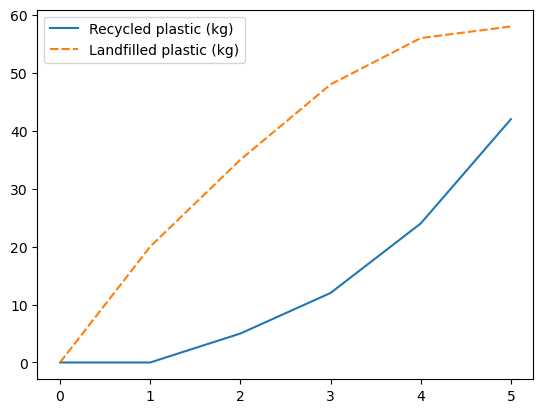

In [212]:
seed = 0
# Here we only use 20 agents to speed up calculations.
model = PlasticRecyclingModel(seed=seed, num_households=20, initial_recycling_rate=0.1, 
                              behavior_costs={'recycling': [0.3, 0.7], 'landfilling': 0.5},
                              decision_weights={'attitude': 0.3, 'subjective norms': 0.3,
                                                'perceived behavioural control': -0.3, 'environmental knowledge': 1})

# Here we only use run the model for 5 steps to speed up calculations.    
for i in range(6):
    print('Step', i)
    model.step()

results_model = model.data_collector.get_model_vars_dataframe()

# Plot results.
waste_fate = results_model.drop('Climate change impact (kg CO₂ eq)', axis=1)
sns.lineplot(data=waste_fate);

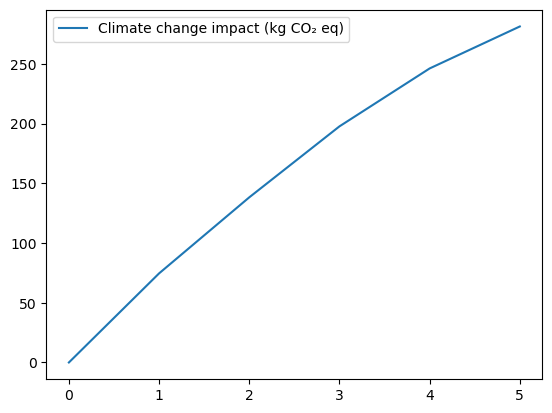

In [213]:
# Plot results.
cc_impact = results_model.drop(['Recycled plastic (kg)', 'Landfilled plastic (kg)'], axis=1)
sns.lineplot(data=cc_impact);

Now we can also look at the climate change impact at the agent level.

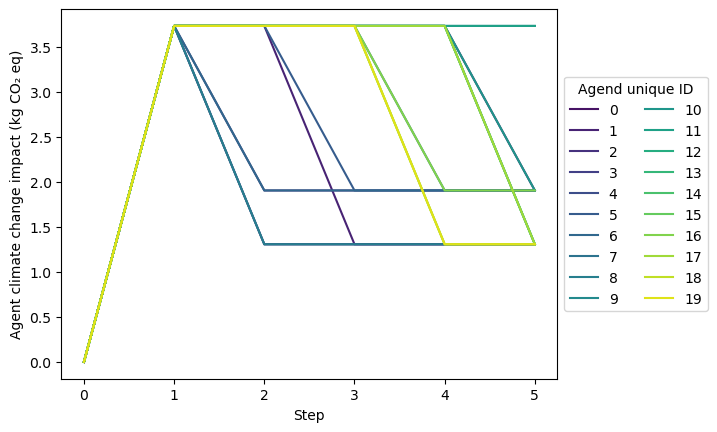

In [214]:
results_agents = model.data_collector.get_agent_vars_dataframe()

# Transform the multi index data frame in a simple data frame so that we can use the Step and AgentID.
results_agents = results_agents.reset_index()
results_agents['AgentID'] = results_agents['AgentID'].apply(lambda x: str(x))

# Plot results.
g = sns.lineplot(x="Step", y="Agent climate change impact (kg CO₂ eq)", hue='AgentID',
                 data=results_agents, palette='viridis')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title="Agend unique ID");

**Quick exercise:** try to shut down the influence of the lca scores on agents decisions (using the "decision_weights" variable). How does it change the results?

Thank you! Don't hesitate to look at our models and publications:

* [CEWAM](https://github.com/NREL/CEWAM).
* [Wind Acceptance Model](https://github.com/jwalzberg/WindAcceptanceModel)
* [Plastic recycling](https://doi.org/10.1016/j.erss.2023.103116)
* [Solar recycling ABM](https://doi.org/10.1038/s41560-021-00888-5)
* [Lessons learned in ABM for the CE](https://doi.org/10.1111/jiec.13423)